# NS_03 Group Project

## Part1

In [1]:
import torch
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datetime
import sklearn.metrics
import pickle

In [2]:
# load data_set, and calculate the mean and std of dataset

# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # 缩放到224 * 224
#     transforms.ToTensor()
# ])

# # 0 -> mask  1-> nonmask  2 -> not a person
# train_dataset = ImageFolder('./data/train', transform=transform)

# # calculate mean of imgs in each RGB channel
# imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
# print(imgs.shape)

# imgs.view(3, -1).mean(dim=1)  # mean of (number of imgs) in each channel
# imgs.view(3, -1).std(dim=1) # std of (number of imgs) in each channel

In [3]:
# load dataset, normarlize it
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 缩放到224 * 224
    # transforms.CenterCrop(256)   #中心剪裁后四周padding补充 (后续可以padding)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4990, 0.4567, 0.4188], std=[0.2913, 0.2778, 0.2836]) 
])

# 0 -> mask  1-> nonmask  2 -> not a person
train_dataset = ImageFolder('./data/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder('./data/test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
# cnn model

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # in=3x256x256; out=32x256x256
            nn.ReLU(),
            nn.MaxPool2d(2), # out=32x128x128
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # in=32x128x128, out=16x128x128
            nn.ReLU(),
            nn.MaxPool2d(2), # out=16x64x64
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # in=16x64x64, out=8x64x64
            nn.ReLU(),
            nn.MaxPool2d(2), # out=8x32x32,
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # 16x16
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(64*16*16, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(32, 3)
        )
    
    def forward(self, x):
        # conv layer
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)
        
        return x


In [5]:
device = (torch.device('cuda') if torch.cuda.is_available() 
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [6]:
# define train_loop function
def train_loop(n_epochs, optimizer, model, loss_fn, train_loader, verbose=1):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_dataloader: # loop over batches in dataset
            # move data to GPU if available
            imgs = imgs.to(device=device)  
            labels = labels.to(device=device)
            
            outputs = model(imgs)  # feed a batch through our model
            
            loss = loss_fn(outputs, labels)  # computes the loss
            
            optimizer.zero_grad()  # getting rid of the gradients from the last round
            
            loss.backward()  # performs backward step, compute the gradients of all parameters
            
            optimizer.step()  # updates the model
            
            loss_train += loss.item() # sums of losses we saw over the epoch

        if verbose == 1: 
        # print the average loss per batch, in epoch%10 == 0 
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)
            ))
        else:
            if epoch == 1 or epoch % 5 == 0:
                print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(), epoch, loss_train/len(train_loader)
                ))

In [7]:
model = CNN().to(device=device)  # instantiates cnn model

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list   # number of parameters, and their shapes

(16837043,
 [432, 16, 2304, 16, 4608, 32, 18432, 64, 16777216, 1024, 32768, 32, 96, 3])

In [8]:
# perform training

learning_rate = 0.001
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()  # use cross entropy loss function

if 'my_model_3.pkl' not in os.listdir():
    # call train_loop() function
    train_loop(
        n_epochs = 15,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader = train_dataloader
    )
    torch.save(model, 'my_model_3.pkl')
else:
    model = torch.load('my_model_3.pkl')

In [9]:
# define validate function
import seaborn as sns
def validate(model, loaders, names, verbose=True):
    model.eval()
    acc = []
    cm = []
    # accuracy on training data and test data
    for name, loader in zip(names, loaders):
        correct = 0
        total = 0
        total_predicted = []
        total_labels = []
        
        with torch.no_grad(): # do not want gradients here, as we will not want to update parameters
            for imgs, labels in loader:
                # move data to GPU if available
                imgs = imgs.to(device=device)  
                labels = labels.to(device=device)
                total_labels.append(labels)
                
                # feed input to models
                outputs = model(imgs)  
                
                # gives the index of the highest value as output
                _, predicted = torch.max(outputs, dim=1)  
                total_predicted.append(predicted)
                
                # counts the number of example, total is increased by the batch size
                total += labels.shape[0]  
            
                correct += int((predicted == labels).sum()) 
                
        total_predicted = torch.hstack(total_predicted).cpu()
        total_labels = torch.hstack(total_labels).cpu()
        cm_ = sklearn.metrics.confusion_matrix(total_labels, total_predicted)

        if verbose:
            print("Accuracy {}: {:.4f}".format(name, correct / total))  
            print(sklearn.metrics.classification_report(total_labels, total_predicted))
        
            sns.heatmap(cm_, annot=True,fmt='d',cmap='Blues')
            plt.title("Confusion matrix of " + name + " data") 
            plt.figure(figsize=(6, 4))
            print()

        acc.append(correct / total)
        cm.append(cm_)
    return acc, cm

Accuracy Training: 0.9952
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       483
           1       1.00      0.99      0.99       490
           2       1.00      1.00      1.00       496

    accuracy                           1.00      1469
   macro avg       1.00      1.00      1.00      1469
weighted avg       1.00      1.00      1.00      1469


Accuracy Testing: 0.8997
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       123
           1       0.94      0.90      0.92       124
           2       0.86      0.92      0.89       102

    accuracy                           0.90       349
   macro avg       0.90      0.90      0.90       349
weighted avg       0.90      0.90      0.90       349




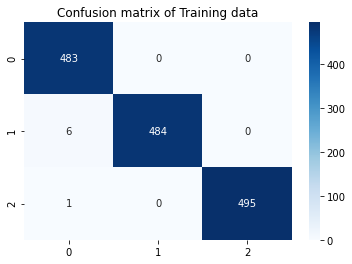

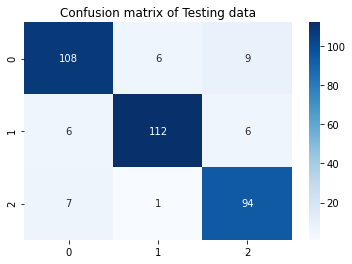

<Figure size 432x288 with 0 Axes>

In [10]:
# measuring accuracy
validate(model, [train_dataloader, test_dataloader], ['Training', 'Testing']);

## Part 2

- Run model on Female test dataset and Male dataset, evaluate their performances.
- Compare their performances, check whether our model has gender bias.

In [11]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

male_dataset = ImageFolder('./data/test_male', transform=transform)
male_dataloader = DataLoader(male_dataset, batch_size=32, shuffle=True)


female_dataset = ImageFolder('./data/test_female', transform=transform)
female_dataloader = DataLoader(female_dataset, batch_size=32, shuffle=True)

Accuracy Male: 0.8810
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       105
           1       0.95      0.92      0.94       105
           2       0.00      0.00      0.00         0

    accuracy                           0.88       210
   macro avg       0.64      0.59      0.61       210
weighted avg       0.96      0.88      0.92       210


/Users/zoufan/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Accuracy Female: 0.9333
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       105
           1       0.97      0.94      0.96       105
           2       0.00      0.00      0.00         0

    accuracy                      

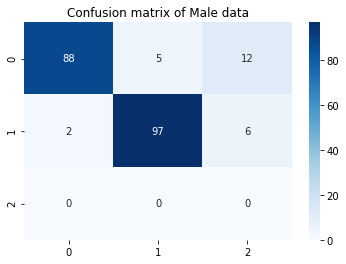

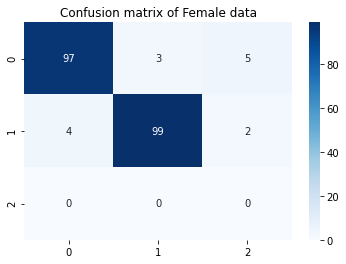

<Figure size 432x288 with 0 Axes>

In [12]:
validate(model, [male_dataloader, female_dataloader], ['Male', 'Female']);

Accuracy of female is 0.84, while accuracy of male is 0.81. Our model has a bias of predicting male with mask as not wearing mask incorrectly.

The reason for this gender bias is that our training dataset is not balance in terms of gender. For example, the training images in Mask folder contains 164 female images, and only 120 male images.

To address this bias, we modified our training dataset, and balanced the number of male images and female images. And then re-training our cnn model on this balanced dataset.

In [13]:
# load balanced dataset
train_balance_dataset = ImageFolder('./data/train_balance', transform=transform)
train_balance_dataloader = DataLoader(train_balance_dataset, batch_size=32, shuffle=True)

# perform training
model_retrained = CNN().to(device=device) 
learning_rate = 0.001
optimizer = optim.Adam(model_retrained.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()  # use cross entropy loss function

if 'my_model_balance_2.pkl' not in os.listdir():
    # call train_loop() function
    train_loop(
        n_epochs = 15,
        optimizer = optimizer,
        model = model_retrained,
        loss_fn = loss_fn,
        train_loader = train_balance_dataloader
    )
    torch.save(model_retrained, 'my_model_balance_2.pkl')
else:
    model_retrained = torch.load('my_model_balance_2.pkl')

Accuracy train: 0.9885
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       489
           1       0.99      0.98      0.98       488
           2       0.99      1.00      1.00       496

    accuracy                           0.99      1473
   macro avg       0.99      0.99      0.99      1473
weighted avg       0.99      0.99      0.99      1473


Accuracy test: 0.9112
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       123
           1       0.92      0.98      0.95       124
           2       0.88      0.86      0.87       102

    accuracy                           0.91       349
   macro avg       0.91      0.91      0.91       349
weighted avg       0.91      0.91      0.91       349




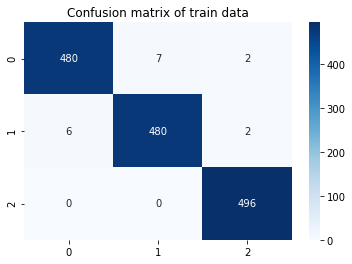

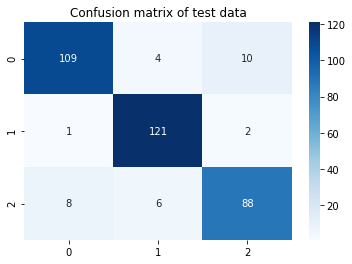

<Figure size 432x288 with 0 Axes>

In [14]:
# evaluation on training and test dataset
validate(model_retrained, [train_balance_dataloader, test_dataloader], ['train', 'test']);

Accuracy Male: 0.9190
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       105
           1       0.97      0.97      0.97       105
           2       0.00      0.00      0.00         0

    accuracy                           0.92       210
   macro avg       0.66      0.61      0.63       210
weighted avg       0.99      0.92      0.95       210


Accuracy Female: 0.9571
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       105
           1       0.97      0.99      0.98       105
           2       0.00      0.00      0.00         0

    accuracy                           0.96       210
   macro avg       0.65      0.64      0.65       210
weighted avg       0.98      0.96      0.97       210




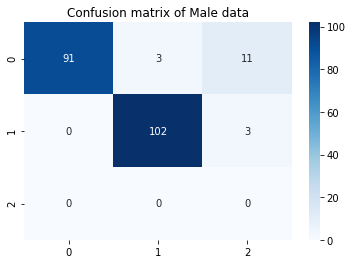

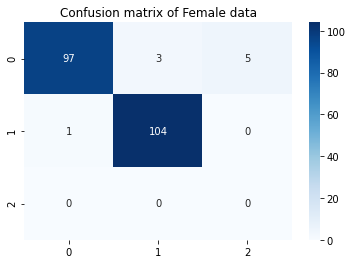

<Figure size 432x288 with 0 Axes>

In [15]:
# evaluation on Female and Male test dataset
validate(model_retrained, [male_dataloader, female_dataloader], ['Male', 'Female']);

### K-Fold cross validation

In [16]:
# Merge original training dataset and test dataset
total_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

# Merge re-balanced training dataset and test dataset
total_balanced_dataset = torch.utils.data.ConcatDataset([train_balance_dataset, test_dataset])

In [17]:
def kfold_evaluation(dataset, cnn_model):
    X, y = zip(*dataset)
    X = np.array([item.numpy() for item in X])
    y = np.array(y)
    skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

    i = 1
    accuracy_result = []
    cm_result = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        dataset_train = list(zip(X_train, y_train))
        dataset_test = list(zip(X_test, y_test))

        dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
        dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

        print('------------- {}th split -------------'.format(i))

        # perform training on dataset_train
        """
        model_ = CNN().to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model_.parameters(), lr=learning_rate)
        loss_fn = nn.CrossEntropyLoss()  # use cross entropy loss function

        model_filename = 'kfold_model_balanced' + str(i) + '.pkl'
        if model_filename not in os.listdir():
            # call train_loop() function
            train_loop(
                n_epochs = 15,
                optimizer = optimizer,
                model = model_,
                loss_fn = loss_fn,
                train_loader = dataloader_train,
                verbose=0
            )
            torch.save(model_, model_filename)
        else:
            model_ = torch.load(model_filename)
        """

        acc, cm = validate(cnn_model, [dataloader_train, dataloader_test], ['Train', 'Test'],
                            verbose=False)
        accuracy_result.append(acc)
        cm_result.append(cm) 
        i += 1

    return accuracy_result, cm_result


In [18]:
if 'accuracy_result' not in os.listdir():
    accuracy_result, cm_result = kfold_evaluation(total_dataset, model)
    with open('accuracy_result', 'wb') as f:
        pickle.dump(accuracy_result, f)
    with open('cm_result', 'wb') as f2:
        pickle.dump(cm_result, f2)
else:
    accuracy_result = pickle.load(open('accuracy_result', 'rb'))
    cm_result = pickle.load(open('cm_result', 'rb'))


Traning accuracy of 1th split: 0.976161369193154
Testing accuracy of 1th split: 0.9835164835164835

Traning accuracy of 2th split: 0.9773838630806846
Testing accuracy of 2th split: 0.9725274725274725

Traning accuracy of 3th split: 0.9749388753056235
Testing accuracy of 3th split: 0.9945054945054945

Traning accuracy of 4th split: 0.9767726161369193
Testing accuracy of 4th split: 0.978021978021978

Traning accuracy of 5th split: 0.9779951100244498
Testing accuracy of 5th split: 0.967032967032967

Traning accuracy of 6th split: 0.9767726161369193
Testing accuracy of 6th split: 0.978021978021978

Traning accuracy of 7th split: 0.9779951100244498
Testing accuracy of 7th split: 0.967032967032967

Traning accuracy of 8th split: 0.9767726161369193
Testing accuracy of 8th split: 0.978021978021978

Traning accuracy of 9th split: 0.9761759315821625
Testing accuracy of 9th split: 0.9834254143646409

Traning accuracy of 10th split: 0.9780085522296884
Testing accuracy of 10th split: 0.96685082872

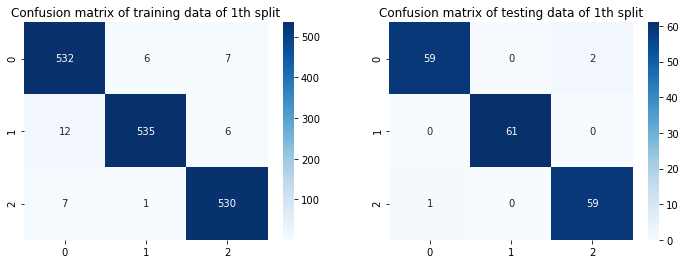

<Figure size 432x288 with 0 Axes>

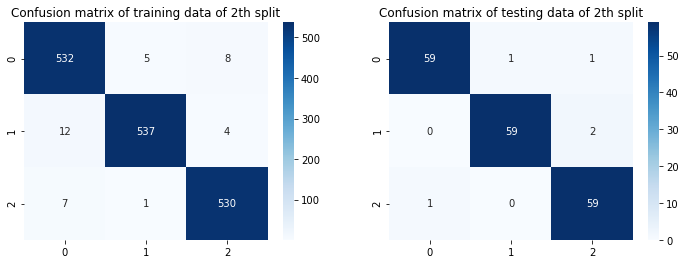

<Figure size 432x288 with 0 Axes>

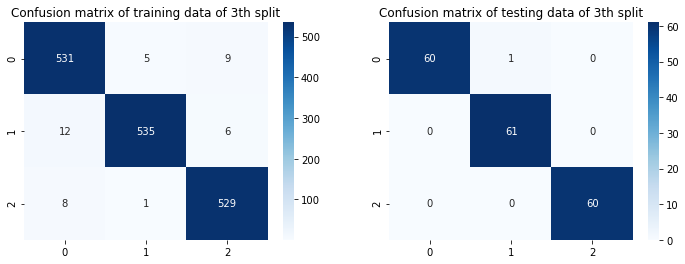

<Figure size 432x288 with 0 Axes>

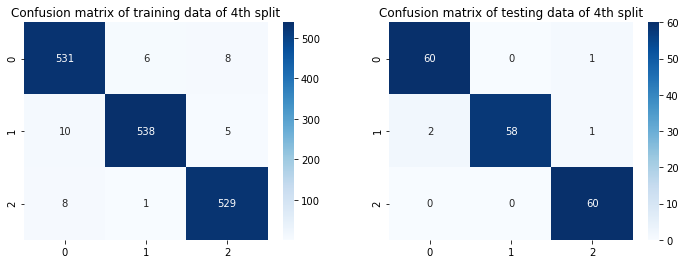

<Figure size 432x288 with 0 Axes>

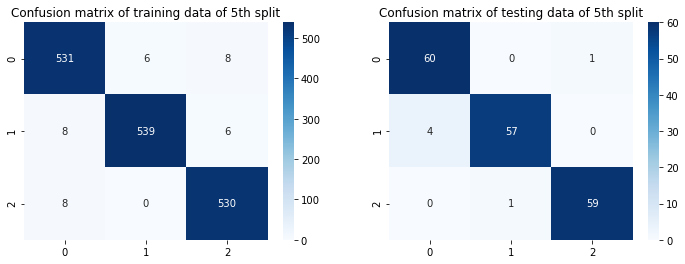

<Figure size 432x288 with 0 Axes>

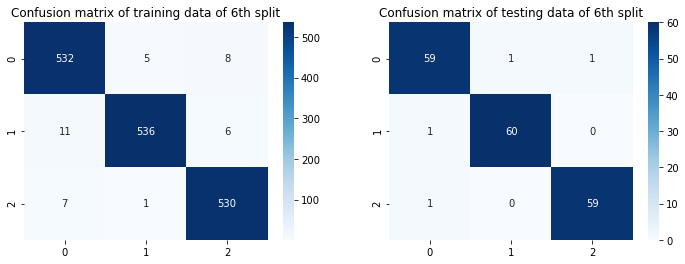

<Figure size 432x288 with 0 Axes>

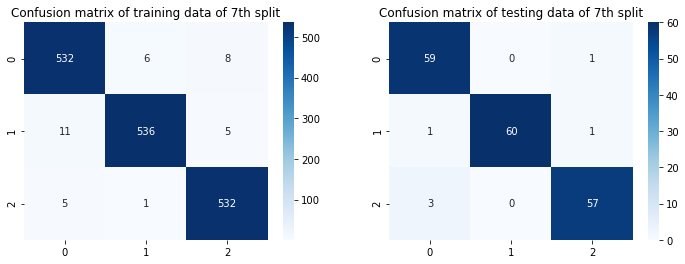

<Figure size 432x288 with 0 Axes>

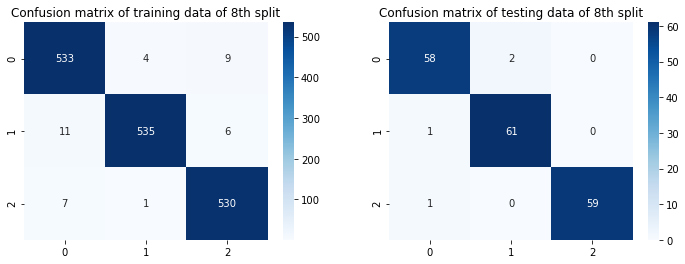

<Figure size 432x288 with 0 Axes>

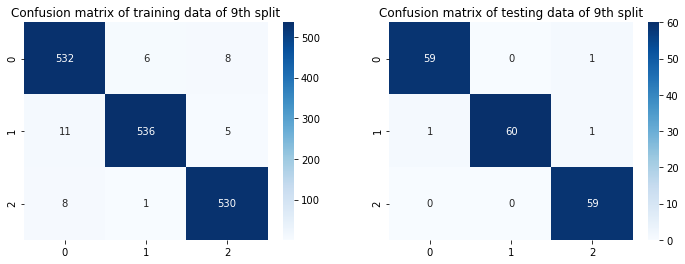

<Figure size 432x288 with 0 Axes>

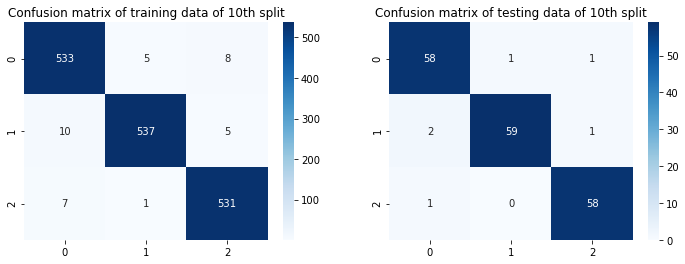

<Figure size 432x288 with 0 Axes>

In [19]:
for i, acc in enumerate(accuracy_result):
    print("\nTraning accuracy of {}th split: ".format(i+1) + str(acc[0]))
    print("Testing accuracy of {}th split: ".format(i+1) + str(acc[1]))

print()
for j, cm in enumerate(cm_result):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm[0], annot=True,fmt='d',cmap='Blues')
    plt.title("Confusion matrix of training data of {}th split".format(j+1)) 

    plt.subplot(1, 2, 2)
    sns.heatmap(cm[1], annot=True,fmt='d',cmap='Blues')
    plt.title("Confusion matrix of testing data of {}th split".format(j+1)) 
    plt.figure(figsize=(6, 4))

In [20]:
if 'accuracy_result_balanced' not in os.listdir(): 
    accuracy_result_balanced, cm_result_balanced = kfold_evaluation(total_balanced_dataset, model_retrained)
    with open('accuracy_result_balanced', 'wb') as f3:
        pickle.dump(accuracy_result_balanced, f3)
    with open('cm_result_balanced', 'wb') as f4:
        pickle.dump(cm_result_balanced, f4)
else:
    accuracy_result_balanced = pickle.load(open('accuracy_result_balanced', 'rb'))
    cm_result_balanced = pickle.load(open('accuracy_result_balanced', 'rb'))


Traning accuracy of 1th split of retrained model: 0.9725442342892008
Testing accuracy of 1th split of retrained model: 0.9836065573770492

Traning accuracy of 2th split of retrained model: 0.9737644905430141
Testing accuracy of 2th split of retrained model: 0.9726775956284153

Traning accuracy of 3th split of retrained model: 0.975609756097561
Testing accuracy of 3th split of retrained model: 0.9560439560439561

Traning accuracy of 4th split of retrained model: 0.975
Testing accuracy of 4th split of retrained model: 0.9615384615384616

Traning accuracy of 5th split of retrained model: 0.973170731707317
Testing accuracy of 5th split of retrained model: 0.978021978021978

Traning accuracy of 6th split of retrained model: 0.973780487804878
Testing accuracy of 6th split of retrained model: 0.9725274725274725

Traning accuracy of 7th split of retrained model: 0.973780487804878
Testing accuracy of 7th split of retrained model: 0.9725274725274725

Traning accuracy of 8th split of retrained m

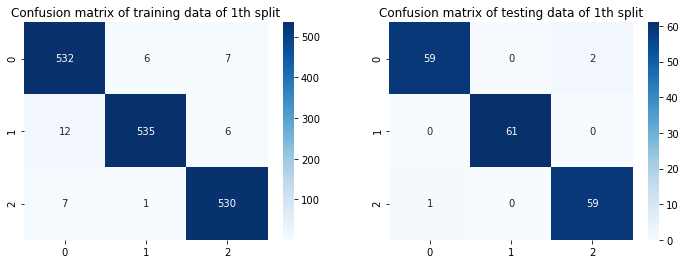

<Figure size 432x288 with 0 Axes>

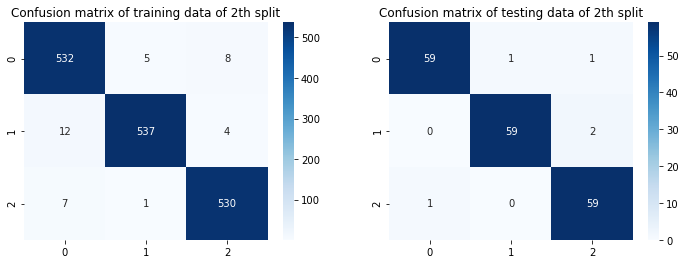

<Figure size 432x288 with 0 Axes>

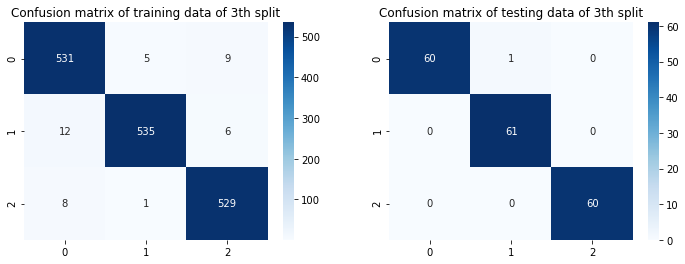

<Figure size 432x288 with 0 Axes>

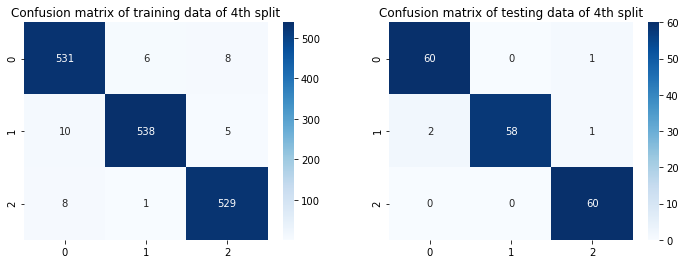

<Figure size 432x288 with 0 Axes>

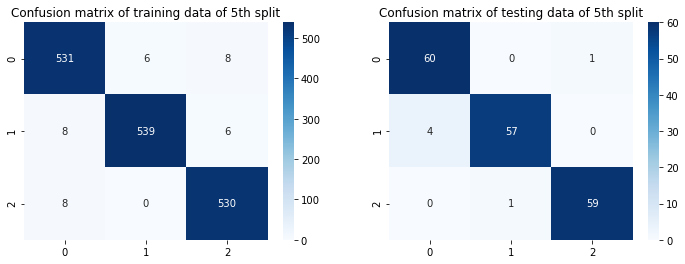

<Figure size 432x288 with 0 Axes>

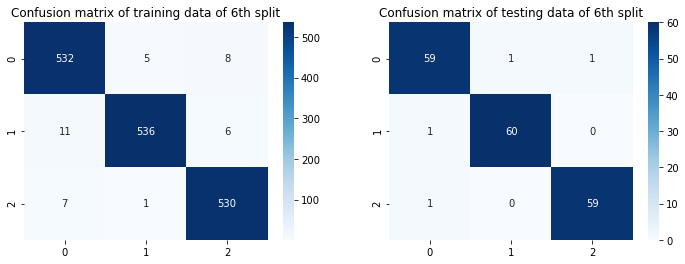

<Figure size 432x288 with 0 Axes>

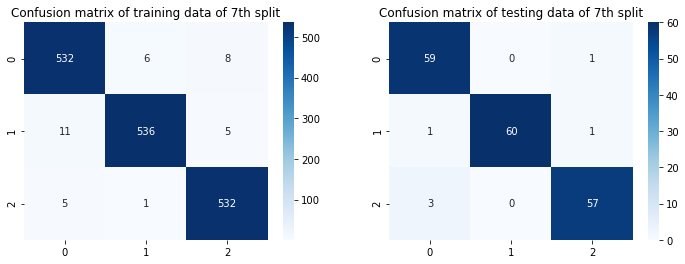

<Figure size 432x288 with 0 Axes>

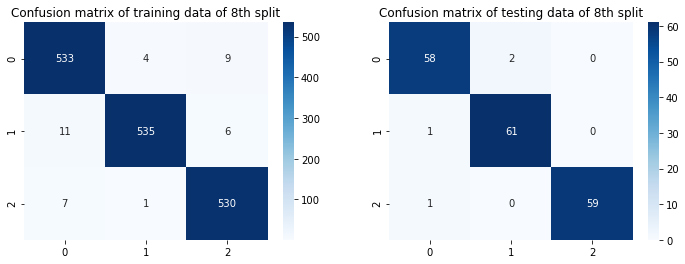

<Figure size 432x288 with 0 Axes>

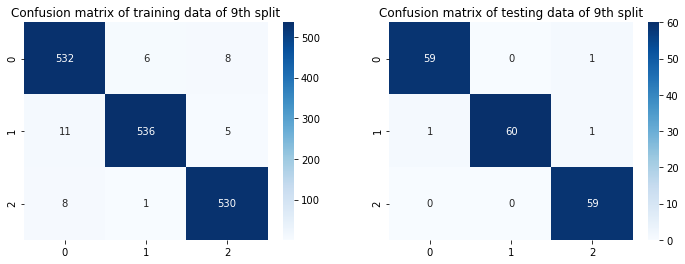

<Figure size 432x288 with 0 Axes>

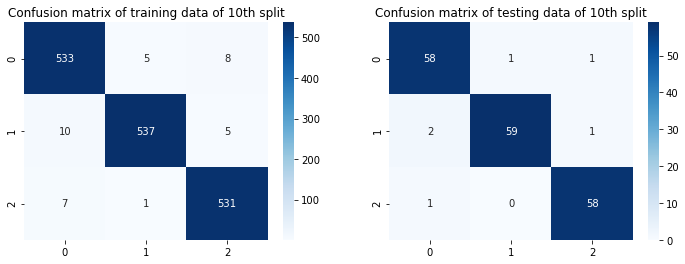

<Figure size 432x288 with 0 Axes>

In [21]:
for i, acc in enumerate(accuracy_result_balanced):
    print("\nTraning accuracy of {}th split of retrained model: ".format(i+1) + str(acc[0]))
    print("Testing accuracy of {}th split of retrained model: ".format(i+1) + str(acc[1]))

print()
for j, cm in enumerate(cm_result):
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm[0], annot=True,fmt='d',cmap='Blues')
    plt.title("Confusion matrix of training data of {}th split".format(j+1)) 

    plt.subplot(1, 2, 2)
    sns.heatmap(cm[1], annot=True,fmt='d',cmap='Blues')
    plt.title("Confusion matrix of testing data of {}th split".format(j+1)) 
    plt.figure(figsize=(6, 4))

In [22]:
# calculate average accuracy
train_acc = 0
test_acc = 0
for acc in accuracy_result:
    train_acc += acc[0]
    test_acc += acc[1]
print('KFold on original dataset')
print('Average accuracy is: {:.4f}'.format(train_acc / 10))

KFold on original dataset
Average accuracy is: 0.9769


In [23]:
train_acc = 0
test_acc = 0
for acc in accuracy_result_balanced:
    train_acc += acc[0]
    test_acc += acc[1]
print('KFold on balanced dataset')
print('Average accuracy is: {:.4f}'.format(train_acc / 10))

KFold on balanced dataset
Average accuracy is: 0.9737
